We propose a set of interactive visualization panel plots for active learning based on prediction values, inspired by the background that there is limited explainability potential from traditional accuracy/MSE plots.

A sample user interface is as follows. Users are able to select a sample of interesting data points (marked as red points in the second PCA plot) and get a better intuition on how the prediction of those points change through active learning. 

We can also use this tool to compare different querying algorithms simultaneously. Each row in this 3\*3 prediction-change panel plot represents a different strategy ("al", "uc", "rn").

![image1](simulation_3.png)

# 1. Import Packages

We rely on packages:
1. `cv2` to set the user interface and allow human interactions with active learning experiments
2. `sklearn: PCA` to do dimension reduction and create a 2D feature embedding for visualization
3. `matplotlib` to plot the basic Prediction Change 2-D meshgrid visualization 

In [1]:
import numpy as np
import pandas as pd
import cv2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# 2. Read in Dataset and PCA

We use "CASP" regression data as an example. It contains 45,730 instances and 9 attributes. More information is available at: https://networkrepository.com/CASP.php

In [2]:
def scale_zero_one(col):
    """
    Min-max feature scaling for PCA.

    """

    offset = min(col)
    scale = max(col) - min(col)

    col = (col - offset)/scale
    return(col)

## 2.1 Read CASP and Feature Scaling

In [3]:
casp_data = np.genfromtxt('data/CASP.csv', delimiter = ',')
X = casp_data[:,:-1]

for i in range(X.shape[1]):
    X[:,i] = scale_zero_one(X[:,i])

y = casp_data[:,-1]

n,p = X.shape
print(n, p)

45730 9


## 2.2 Load the Test Dataset

In [4]:
### For efficiency, we saved the indices of all 9730 test samples
### Use these indices to extract the test dataset [x] and [y]
y_test_indices = np.load("data/y_test_indices_casp.npz")
y_test_indices['y_test_indices'].shape

y_test_indices_array = y_test_indices['y_test_indices']

x_test = X[y_test_indices_array, : ]
y_test = y[y_test_indices_array]

## 2.3 PCA

The default size of the figure in matplotlib is 432*288 pixels.
We will make use of this characteristic when selecting available points.

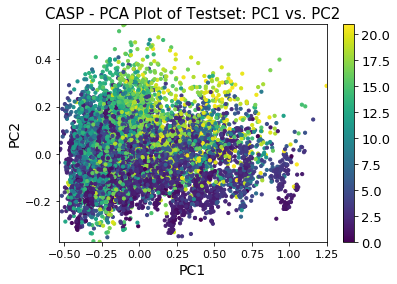

In [5]:
### PCA on the test set
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_test)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

y_df = pd.DataFrame({'y': y_test})

finalDf = pd.concat([principalDf, y_df], axis = 1)
finalDf['dist'] = 0

pc1_max = max(finalDf['principal component 1'])
pc1_min = min(finalDf['principal component 1'])
pc2_max = max(finalDf['principal component 2'])
pc2_min = min(finalDf['principal component 2'])

pca_plot = plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'],
                      s = 10, c = finalDf['y'], cmap='viridis')
plt.title("CASP - PCA Plot of Testset: PC1 vs. PC2", fontsize=15)
plt.xlabel("PC1", fontsize=14)
plt.ylabel("PC2", fontsize=14)
# plt.xticks(fontsize=20, rotation=90)
plt.xticks(fontsize=11)   # Set font size for better visualization
plt.yticks(fontsize=11)
plt.xlim(pc1_min, pc1_max)
plt.ylim(pc2_min, pc2_max)

cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(13)
plt.savefig('plots/pca_casp.jpg')
plt.show()

# 3. Functions for Prediction Change Plots

## 3.1 Utilities

In [6]:
def cal_Euclidean_Distance(x1, y1, x2, y2):
    """
    Return the Euclidean Distance of two points; used to find nearest x number of points later.
    
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

In [7]:
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value

    Derived from: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


## 3.2 Three Prediction Change Plot Functions

In our CASP active learning experiment, we queried a batch of 500 training samples for 15 times. 

###  3.2.1: current model vs. original model

In this example, method should fall into one of {'al', 'rn', 'uc'}

In [8]:
def pred_change_query_plot_original(method, indices_neighbor_points):
    """
    Plot the Prediction Change plot from current model vs. original model.
    Save the figure locally and re-use later for human interactions.
    
    Notice: the FIRST column of x-axis = 0 should be all white (0 difference), as it is the first model vs. first model.
    
    """
    
    ### Load the prediction values on the test set
    predic_file = np.load("data/predictions_" + method + "_casp.npz")
    predictions = predic_file['predictions_'+ method + '_values']
    
    ### Because our experiment ran 4 times for different seeds, we average the prediction results    
    predictions_mean_every_4 = predictions.transpose().reshape(-1,4).mean(1).reshape(y_test_indices['y_test_indices'].shape[0]
                                                                                     ,-1).transpose()
    ### Subset the prediction values for neighbor points only 
    subset_predictions = predictions_mean_every_4[:,indices_neighbor_points]
    
    ### Initialize an array to store values of prediction difference 
    diff_predictions = []
    originl_predictions = subset_predictions[0]
    for i in range(len(subset_predictions)):
        curr_predict = subset_predictions[i]
        curr_diff = curr_predict-originl_predictions
        diff_predictions.append(curr_diff.tolist())

    ### Min-max scale the prediction values to normalize the color bar
    diff_predictions_np = np.array(diff_predictions)
    elev_min=diff_predictions_np.transpose().min()
    elev_max=diff_predictions_np.transpose().max()
    mid_val=0
    
    # plt.figure(figsize=(432,288))   ### This is the default figure size
    plt.figure(figsize=(4.15,4))
    plt.imshow(diff_predictions_np.transpose().tolist(), cmap = plt.get_cmap('seismic'), 
               clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
    cbar = plt.colorbar()
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(14)
    plt.xticks(range(0,15), labels = range(1,16), fontsize = 10)
    plt.yticks(range(0,20), labels = range(1,21), fontsize = 10)
    plt.title("Pred: curr. model vs. orig. model ("+ method+")", fontsize=15)
    plt.xlabel("Query Batches", fontsize=15)
    plt.ylabel("Test Sample Indices", fontsize=15)
    plt.savefig("plots/change_query_plot_original_" + method +".jpg")
    plt.show()

### 3.2.2 current model vs. previous model

In [18]:
def pred_change_query_plot_prev(method, indices_neighbor_points):
    """
    Plot the Prediction Change plot from current model vs. previous model.
    Save the figure locally and re-use later for human interactions.
    
    Notice: the LAST column of this meshgrid plot should be all white (0 difference).
    
    """
    
    ### Load the prediction values on the test set
    predic_file = np.load("data/predictions_" + method + "_casp.npz")
    predictions = predic_file['predictions_'+ method + '_values']
    
    ### Because our experiment ran 4 times for different seeds, we average the prediction results    
    predictions_mean_every_4 = predictions.transpose().reshape(-1,4).mean(1).reshape(y_test_indices['y_test_indices'].shape[0],
                                                                                     -1).transpose()
    ### Subset the prediction values for neighbor points only     
    all_predictions = predictions_mean_every_4[:,indices_neighbor_points]
    
    ### Initialize an array to store values of prediction difference 
    diff_pre_predictions = []
    for i in range(len(all_predictions)):
        if i == 0:
            diff_pre_predictions.append(all_predictions[0]-all_predictions[0])
        if i>=1:
            curr_predict = all_predictions[i]
            pre_predict = all_predictions[i-1]

            curr_pre_diff = curr_predict-pre_predict
            diff_pre_predictions.append(curr_pre_diff.tolist())

    ### Min-max scale the prediction values to normalize the color bar
    diff_pre_predictions_np = np.array(diff_pre_predictions)
    elev_min=diff_pre_predictions_np.transpose().min()
    elev_max=diff_pre_predictions_np.transpose().max()
    mid_val=0

    plt.figure(figsize=(4.15,4))
    plt.imshow(diff_pre_predictions_np.transpose().tolist(), cmap = plt.get_cmap('seismic'),
               clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
    cbar = plt.colorbar()
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(14)
    plt.xticks(range(0,15), labels = range(1,16), fontsize = 10)
    plt.yticks(range(0,20), labels = range(1,21), fontsize = 10)
    plt.title("Pred: curr. model vs. prev. model ("+ method+")", fontsize=15)
    plt.xlabel("Query Batches", fontsize=15)
    plt.ylabel("Test Sample Indices", fontsize=15)
    plt.savefig("plots/change_query_plot_prev_" + method +".jpg")
    plt.show()

### 3.2.3  current model vs. ground truth

In [17]:
def pred_change_query_plot_truth(method, indices_neighbor_points, df_neighbor_points):
    """
    Plot the Prediction Change plot from current model vs. ground truth.
    Save the figure locally and re-use later for human interactions.
    
    """
    
    ### Load the prediction values on the test set
    predic_file = np.load("data/predictions_" + method + "_casp.npz")
    predictions = predic_file['predictions_'+ method + '_values']
    
    ### Because our experiment ran 4 times for different seeds, we average the prediction results  
    predictions_mean_every_4 = predictions.transpose().reshape(-1,4).mean(1).reshape(y_test_indices['y_test_indices'].shape[0],
                                                                                     -1).transpose()
    ### Subset the prediction values for neighbor points only     
    all_predictions = predictions_mean_every_4[:,indices_neighbor_points]
    
    y_truth = df_neighbor_points['y']

    ### Initialize an array to store values of prediction difference 
    ground_truth_predictions = []
    for i in range(len(all_predictions)):
        curr_predict = all_predictions[i]

        curr_diff = curr_predict-y_truth
        ground_truth_predictions.append(curr_diff.tolist())
    
    ### Min-max scale the prediction values to normalize the color bar
    elev_min=np.array(ground_truth_predictions).min()
    elev_max=np.array(ground_truth_predictions).max()
    mid_val=0
    
    plt.figure(figsize=(4.15,4))
    plt.imshow(np.array(ground_truth_predictions).transpose().tolist(), cmap = plt.get_cmap('seismic'), 
               clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
    cbar = plt.colorbar()
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(14)
    plt.xticks(range(0,15), labels = range(1,16), fontsize = 10)
    plt.yticks(range(0,20), labels = range(1,21), fontsize = 10)
    plt.title("Pred: curr. model vs. truth ("+ method+")", fontsize=15)
    plt.xlabel("Query Batches", fontsize=15)
    plt.ylabel("Test Sample Indices", fontsize=15)
    plt.savefig("plots/change_query_plot_truth_" + method +".jpg")
    plt.show()

## 3.3 A static example: mid points of CASP PCA 

Use the centric position of the PCA plot as an example. Remember that the graph is 432*288 size. Select nearest 20 points.

In [11]:
a = 432/2
b = 288/2

### our cursor must fall into the internal recantangle region which contains all points.
### Otherwise it makes no sense as we do not select any point inside. 
if a >= 55 and a <= 323 and b >= 35 and b <= 253:
    ### Some simple algebra to get 
    a_x_value = (a-55)/268*(pc1_max-pc1_min)+pc1_min
    b_y_value = pc2_max-((b-35)/218*(pc2_max-pc2_min))
    
finalDf['dist'] = finalDf.apply(lambda x: cal_Euclidean_Distance(x['principal component 1'], 
                                                                 x['principal component 2']
                                                        , a_x_value, b_y_value), axis = 1 )

### Get the prediction values of 20 nearest points of the centric point
nearest_20_points_df = finalDf.nsmallest(20, 'dist')
nearest_20_points_df_indices = nearest_20_points_df.index

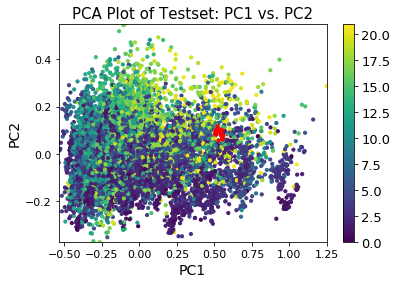

In [14]:
### The red points mark the nearest 20 points of the centric
pca_plot = plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'],
                      s = 10, c = finalDf['y'], cmap='viridis')
plt.title("PCA Plot of Testset: PC1 vs. PC2", fontsize=15)
plt.xlabel("PC1", fontsize=14)
plt.ylabel("PC2", fontsize=14)

plt.xticks(fontsize=11)   # Set font size for better visualization
plt.yticks(fontsize=11)

plt.xlim(pc1_min, pc1_max)
plt.ylim(pc2_min, pc2_max)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(13)
plt.scatter(nearest_20_points_df['principal component 1'], nearest_20_points_df['principal component 2'],
           c = "r", s = 10)

plt.savefig('plots/pca_1_casp.jpg')
plt.show()

### 3.3.1  current model vs. original model¶

We are interested in prediction values from an active learning algorithm "al"

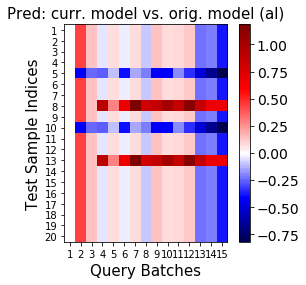

In [15]:
pred_change_query_plot_original('al', nearest_20_points_df_indices)

### 3.3.2 current model vs. previous model¶

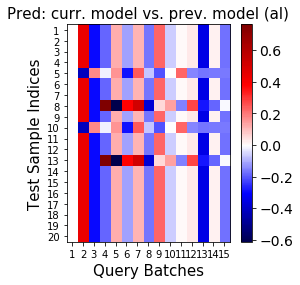

In [19]:
pred_change_query_plot_prev('al', nearest_20_points_df_indices)

### 3.3.3  current model vs. ground truth

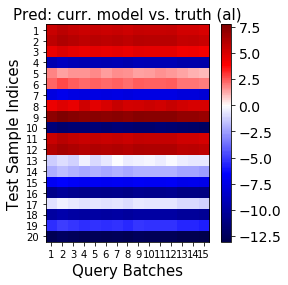

In [20]:
pred_change_query_plot_truth('al', nearest_20_points_df_indices, nearest_20_points_df)

# 4. User Interface for Active Learning Visualization

## 4.1 Utilities

We utilize the "cv2" package to arrange the PCA plot and different Prediction Change plots. Each graph is treated as a 2-d array.

In [21]:
def hconcat_resize(img_list, interpolation = cv2.INTER_CUBIC):
    """
    Resize the graphs to make them be able to concatnate horizontally.
    
    """
    # take minimum hights
    h_min = min(img.shape[0] for img in img_list)
      
    # image resizing 
    im_list_resize = [cv2.resize(img,(int(img.shape[1] * h_min / img.shape[0]),
                        h_min), interpolation = interpolation) for img in img_list]
      
    # return final image
    return cv2.hconcat(im_list_resize)

def vconcat_resize(img_list, interpolation = cv2.INTER_CUBIC):
    """
    Resize the graphs to make them be able to concatnate vertically.
    
    """
    # take minimum width
    w_min = min(img.shape[1] for img in img_list)
      
    # resizing images
    im_list_resize = [cv2.resize(img,(w_min, int(img.shape[0] * w_min / img.shape[1])),
                                 interpolation = interpolation) for img in img_list]
    # return final image
    return cv2.vconcat(im_list_resize)


def concat_tile_resize(list_2d, interpolation = cv2.INTER_CUBIC):
    """
    Resize the graphs and tile them together.
    
    """
    # function calling for every list of images
    img_list_v = [hconcat_resize(list_h, interpolation = cv2.INTER_CUBIC) for list_h in list_2d]
      
    # return final image
    return vconcat_resize(img_list_v, interpolation=cv2.INTER_CUBIC)

## 4.2 Set the Interaction Platform

In [22]:
def on_EVENT_LBUTTONDOWN(event, x, y, flags, param):
    """
    A single click from cursor triggers an event. We mark a point and get the Prediction Change plots 
    for its nearest 20 points.
    
    """
    
    if event == cv2.EVENT_LBUTTONDOWN:
        xy = "%d,%d" % (x, y)
        print(xy)
        
                
        img = cv2.imread("plots/pca_casp.jpg")   ### Read in the general PCA plot
        img1 = cv2.imread("misc/empty.jpg")     ### Read in the empty 432*288 graph
        
        ### Must fall into the rectangle region to be a valid point
        if x >= 55 and x <= 323 and y >= 35 and y <= 253:
        
            ### Add the coordinates from the cursor
            a_x_value = (x-55)/268*(pc1_max-pc1_min)+pc1_min
            b_y_value = pc2_max-((y-35)/218*(pc2_max-pc2_min))
            x_y_value = "%.4f,%.4f" % (a_x_value, b_y_value)
            print(x_y_value)

            ### Circle the location of our cursor
            cv2.circle(img, (x, y), 1, (243,34,215), thickness = 1)
            cv2.putText(img, x_y_value, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.0, (0,0,0), thickness = 1)
        
            ### Second Plot: Mark the nearest points. 
            finalDf['dist'] = finalDf.apply(lambda x: cal_Euclidean_Distance(x['principal component 1'], 
                                                                 x['principal component 2']
                                                        , a_x_value, b_y_value), axis = 1 )

            ### 20 nearest points are good for visualization
            nearest_neighbor_points_df = finalDf.nsmallest(20, 'dist')
            nearest_neighbor_points_df_indices = nearest_neighbor_points_df.index
        
            
            pca_plot = plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'],
                      s = 10, c = finalDf['y'], cmap='viridis')
            plt.title("PCA Plot of Testset: PC1 vs. PC2", fontsize=15)
            plt.xlabel("PC1", fontsize=14)
            plt.ylabel("PC2", fontsize=14)
            plt.xticks(fontsize=11)  
            plt.yticks(fontsize=11)
            plt.xlim(pc1_min, pc1_max)
            plt.ylim(pc2_min, pc2_max)
            cbar = plt.colorbar()
            for t in cbar.ax.get_yticklabels():
                 t.set_fontsize(13)
            plt.scatter(nearest_neighbor_points_df['principal component 1'], nearest_neighbor_points_df['principal component 2'],
                       c = "r", s = 10)

            plt.savefig('plots/pca_1.jpg')
            plt.show()
            
            #########
            ### Active Learning
            #########
            
            ### First Plot: Prediction Change original
            pred_change_query_plot_original('al', nearest_neighbor_points_df_indices)
            
            ### Second Plot: Prediction Change previous
            pred_change_query_plot_prev('al', nearest_neighbor_points_df_indices)
            
            ### Third Plot: Prediction Change truth
            pred_change_query_plot_truth('al', nearest_neighbor_points_df_indices, nearest_neighbor_points_df)
            

            #########
            ### Uncertainty Sampling
            #########
            
            ### Fourth Plot: Prediction Change original
            pred_change_query_plot_original('uc', nearest_neighbor_points_df_indices)

            ### Fifth Plot: Prediction Change previous
            pred_change_query_plot_prev('uc', nearest_neighbor_points_df_indices)
            
            ### Sixth Plot: Prediction Change truth
            pred_change_query_plot_truth('uc', nearest_neighbor_points_df_indices, nearest_neighbor_points_df)
            
            
            #########
            ### Random Sampling
            #########
            
            ### Seventh Plot: Prediction Change original
            pred_change_query_plot_original('rn', nearest_neighbor_points_df_indices)
            
            ### Eighth Plot: Prediction Change previous
            pred_change_query_plot_prev('rn', nearest_neighbor_points_df_indices)
            
            ### Ninth Plot: Prediction Change truth
            pred_change_query_plot_truth('rn', nearest_neighbor_points_df_indices, nearest_neighbor_points_df)
            
        
        img2 = cv2.imread("plots/pca_1.jpg")     ### PCA with marked point
        
        ### Active Learning
        img3 = cv2.imread("plots/change_query_plot_original_al.jpg")
        img4 = cv2.imread("plots/change_query_plot_prev_al.jpg")
        img5 = cv2.imread("plots/change_query_plot_truth_al.jpg")
        
        ### Uncertainty Sampling
        img6 = cv2.imread("plots/change_query_plot_original_uc.jpg")
        img7 = cv2.imread("plots/change_query_plot_prev_uc.jpg")
        img8 = cv2.imread("plots/change_query_plot_truth_uc.jpg")
        
        ### Random Sampling
        img9 = cv2.imread("plots/change_query_plot_original_rn.jpg")
        img10 = cv2.imread("plots/change_query_plot_prev_rn.jpg")
        img11 = cv2.imread("plots/change_query_plot_truth_rn.jpg")
        
        
        # cv2.imshow("image", final)
        
        ### Layout all graphs properly 
        im_tile_resize = concat_tile_resize([[img1, img1, img3, img4, img5],
                                     [img, img2, img6, img7, img8], 
                                      [img1, img1, img9, img10, img11] ])
        ### Display the concatenated image
        cv2.imshow('plots/concat_tile_resize.jpg', im_tile_resize)

## 4.3 Call the Interaction Platform

284,213
0.9880,-0.2034


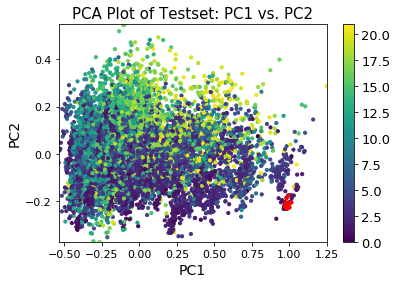

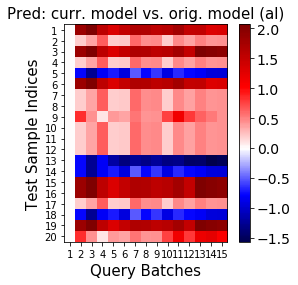

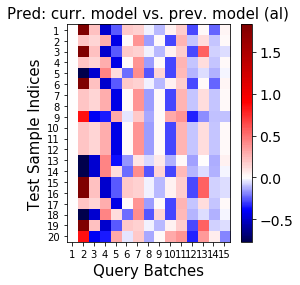

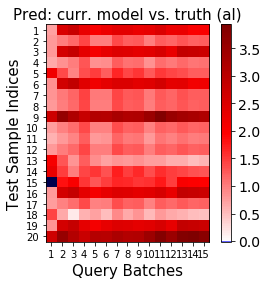

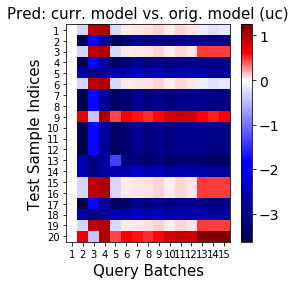

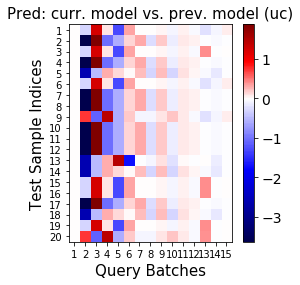

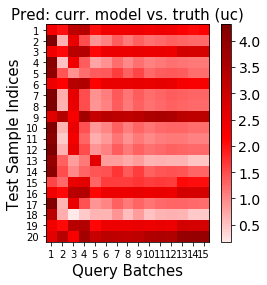

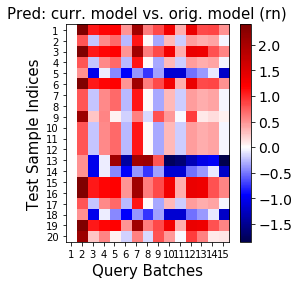

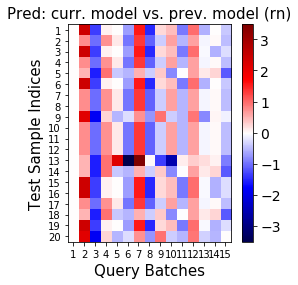

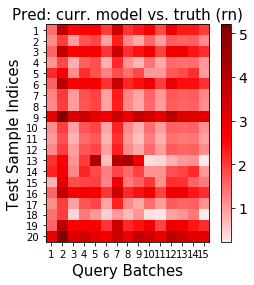

188,58
0.3481,0.4512


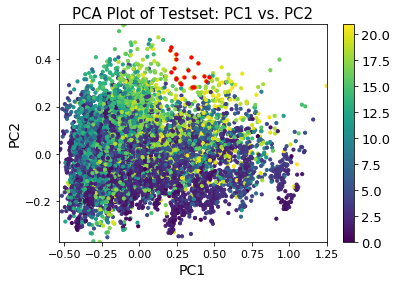

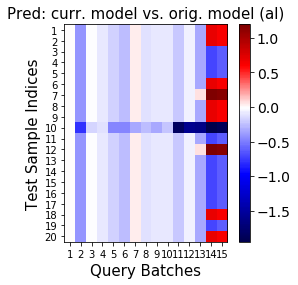

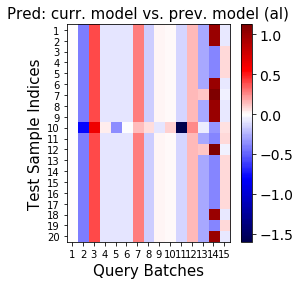

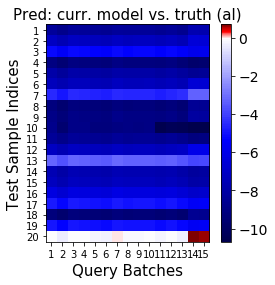

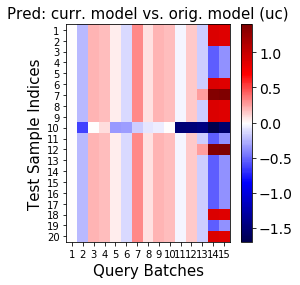

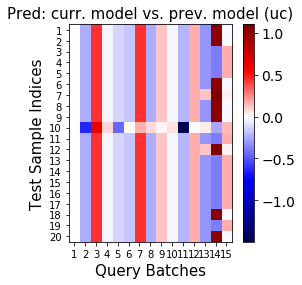

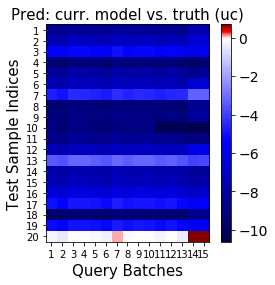

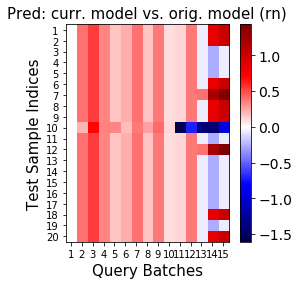

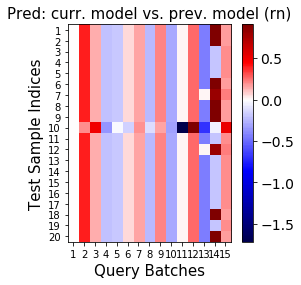

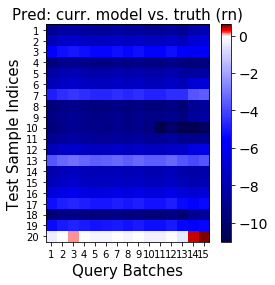

177,52
0.2748,0.4765


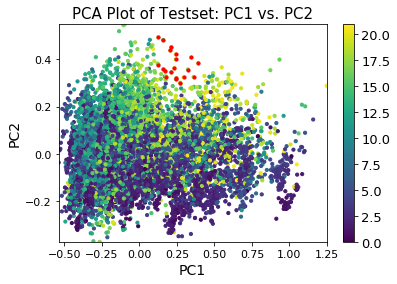

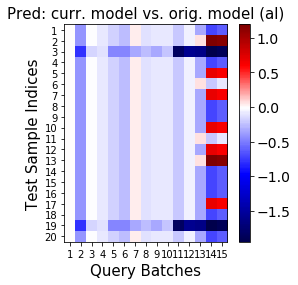

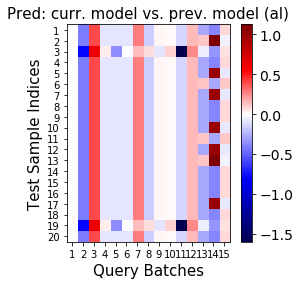

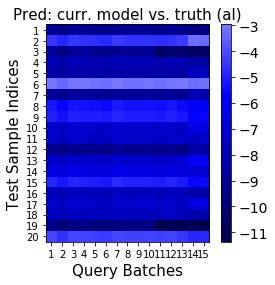

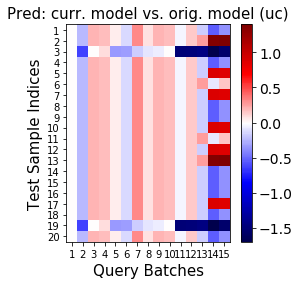

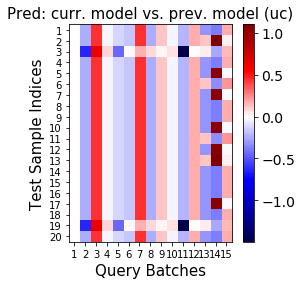

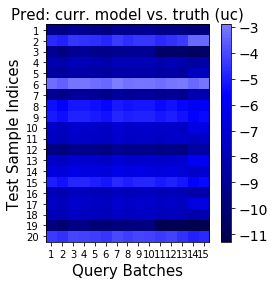

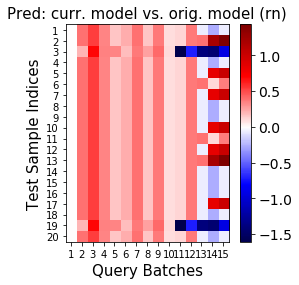

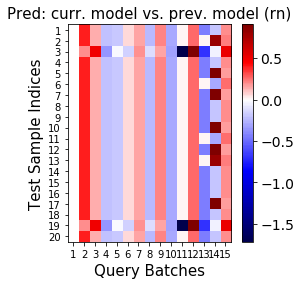

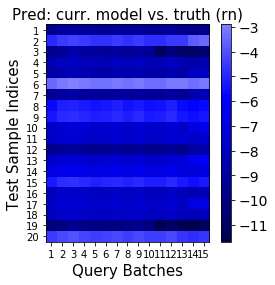

-1

In [23]:
### We initialize the original PCA plot. Then select the points inside.
img = cv2.imread("plots/pca_casp.jpg")

cv2.namedWindow("image")
cv2.setMouseCallback("image", on_EVENT_LBUTTONDOWN)
cv2.imshow("image", img)

### End visualization platform by typing anything
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

# 5. Simulations 

In this section, we exhibit a few simulation results by selecting different group of points. 

## 5.1 Simulation 1: a group of small values 

![test](simulation_1.png)

## 5.2 Simulation 2: a group of large values 

![Simulation2.png](simulation_2.png)

## 5.3 Simulation 3: a group of mixed small and large values

![Simulation3.png](simulation_3.png)